In [135]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
#from sklearn.multioutput import MultiOutputClassifi

## Part 1

In [171]:
class Markov_model:
    def __init__(self, T = 10, n = 2, alpha = 0.9, beta = 0.2, gamma = 0.1, lamb0 = 1, lamb1  = 5) -> None:
        #Customizable values
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.lamb0 = lamb0
        self.lamb1 = lamb1
        self.T = T
        self.n = n


        #--- Given probabilities---
        self.prob_C1 = np.array([0,0,1])
        self.Z_given_C = np.array([[self.alpha, 1-self.alpha],[1-self.alpha, self.alpha], [0.5, 0.5]])  #(C, Z)
        self.alpha_C = np.array([1-self.alpha, self.alpha, 0.5])

        self.rates = [self.lamb0, self.lamb1]
        self.Gamma = np.array([[1-self.gamma, 0, self.gamma], #(Ci, Ci_plus1)
                          [0, 1-self.gamma, self.gamma], 
                          [self.beta/2, self.beta/2, 1-self.beta]])
        self.model_values = [self.lamb0, self.lamb1, self.alpha, self.beta, self.gamma] 
        
    def update_values(self):
        self.Z_given_C = np.array([[self.alpha, 1-self.alpha],[1-self.alpha, self.alpha], [0.5, 0.5]])  #(C, Z)
        self.rates = [self.lamb0, self.lamb1]
        self.Gamma = np.array([[1-self.gamma, 0, self.gamma], #(Ci, Ci_plus1)
                          [0, 1-self.gamma, self.gamma], 
                          [self.beta/2, self.beta/2, 1-self.beta]])
        self.alpha_C = np.array([1-self.alpha, self.alpha, 0.5])
        self.model_values = [self.lamb0, self.lamb1, self.alpha, self.beta, self.gamma]
    
    
    def sim_data(self, n = 0 , T = 0, return_output = True):
        if n == 0:
            n = self.n
        else:
            self.n = n

        if T == 0:
            T = self.T
        else:
            self.T = T
            
        #Defining the three possible values of C
        ck = np.arange(3)   

        #Creating   random variables with probabilities based of the gamma matrix
        C_transition = [
            stats.rv_discrete(values=(ck,self.Gamma[0,])),#P(C_t |C_{t-1} = 0)
            stats.rv_discrete(values=(ck,self.Gamma[1,])),#P(C_t |C_{t-1} = 1)
            stats.rv_discrete(values=(ck,self.Gamma[2,])),#P(C_t |C_{t-1} = 2)
        ]
        
        #Creating output vector of C's
        C = np.zeros(self.T, np.int64)
        
        #Initializing the C vector
        C[0] = 2

        #Filling up the C-vector with values
        for i in range(self.T-1):
            C[i+1] = C_transition[C[i]].rvs()
        self.C = C
        
        #Initializing Z. size=[n,T] specifies we need to create n copies of a series of T simulations
        self.Z = stats.bernoulli([self.Z_given_C[c,1] for c in C]).rvs(size=[self.n,self.T])
        #input:
        '''
        [C_1, C_2, ... C_T]
        '''
        #output: 
        '''[   
            [Z_11, Z_21, Z_31, ... , Z_T1]
            [Z_12, Z_22, Z_32, ... , Z_T2]
            ...
            [Z_1n, Z_2n, Z_3n, ... , Z_Tn]
        ]'''

        #Initialize X   
        self.X = stats.poisson(np.where(self.Z, self.lamb1, self.lamb0)).rvs() #(n, T)
        #input
        '''[   
            [f(Z_11), f(Z_21), f(Z_31), ... , f(Z_T1)]
            [f(Z_12), f(Z_22), f(Z_32), ... , f(Z_T2)]
            ...
            [f(Z_1n), f(Z_2n), f(Z_3n), ... , f(Z_Tn)]
            ]    
            where
            f(z) = lamb0+(lamb1-lamb0)*z
        '''

        #output
        '''[   
            [X_11, X_21, X_31, ... , X_T1]
            [X_12, X_22, X_32, ... , X_T2]
            ...
            [X_1n, X_2n, X_3n, ... , X_Tn]
        ]'''
        if return_output:
            return self.C, self.Z, self.X
        else:
            return
    
    def find_P_X_given_C(self):
        self.P_X_given_Z = np.array([stats.poisson.pmf(k = self.X, mu = self.lamb0), #All of the potentials
                            stats.poisson.pmf(k = self.X, mu = self.lamb1)]) #(Z, n, T)
        
        self.P_X_given_C = np.einsum("ZnT, CZ -> TnC",self.P_X_given_Z, self.Z_given_C) #(Time, n, C)

    def upwards_passing(self):
        #Defining properties
        delta_Mi_to_Li = np.empty(shape = (self.T-1, 3)) #(Time, Ci)
        delta_Li_to_Mi_plus = np.empty(shape = (self.T-1, 3)) #(C_{i+1})
        belief_Li = np.empty(shape = (self.T, 3, 3)) #(T, C_i, C_{i+1})
    
        for i in range(self.T-1):
            #----------------Sending messages-------------
            #finding message Ci, Zi -> Ci+, Ci+
            if i == 0:
                delta_Mi_to_Li[i] = np.prod(self.P_X_given_C[i,:,:], axis = 0)*self.prob_C1 #C1
            else:
                delta_Mi_to_Li[i] = np.prod(self.P_X_given_C[i,:,:], axis = 0)*delta_Li_to_Mi_plus[i-1] #Ci

            #normalizing
            delta_Mi_to_Li[i] /= np.sum(delta_Mi_to_Li[i])

            #Finding belief Li
            belief_Li[i] = np.einsum("cC,c -> cC", self.Gamma, delta_Mi_to_Li[i]) #c old (C_{i}), C new (C_{i+1})
            #normalizing
            belief_Li[i] /= np.sum(belief_Li[i])
            
            #finding message Ci Ci+ -> Ci+, Zi+
            delta_Li_to_Mi_plus[i] = np.sum(belief_Li[i], axis=0) #Summing out c old
            
            #normalizing
            delta_Li_to_Mi_plus[i] /= np.sum(delta_Li_to_Mi_plus[i])

        self.delta_Mi_to_Li = delta_Mi_to_Li
        self.delta_Li_to_Mi_plus = delta_Li_to_Mi_plus
        self.belief_Li = belief_Li
        return 
    
    def backwards_passing(self):
        delta_Mi_plus_to_Li = np.empty(shape= (self.T-1, 3)) #T, C
        delta_Li_to_Mi = np.empty(shape= (self.T -1, 3)) #T, C
        updated_belief_Li = np.empty(shape = (self.T-1, 3, 3)) #T, c old (C_{i}), C new (C_{i+1})       

        for i in range(self.T-1):
            #---- SENDING MESSAGES ----- #
            #find downwards message Mi+ -> Li
            j = self.T -1 - i -1 #finding opposite direvtion
            if i == 0: #then j = T-2, aka the last entry index in messages
                delta_Mi_plus_to_Li[j] = np.prod(self.P_X_given_C[j+1,:,:], axis = 0) #(C)
            else:
                delta_Mi_plus_to_Li[j] = np.prod(self.P_X_given_C[j+1,:,:], axis = 0)*delta_Li_to_Mi[j+1] #(C)
            #normalize
            delta_Mi_plus_to_Li[j] /= np.max(delta_Mi_plus_to_Li[j])

            # find message Li -> Mi
            delta_Li_to_Mi[j] = np.einsum("cC,C -> c", self.Gamma, delta_Mi_plus_to_Li[j]) #Summing out Ci+

            #normalize
            delta_Li_to_Mi[j] /= np.sum(delta_Li_to_Mi[j])

            #----Update clique belief of Li

            #find belief
            updated_belief_Li[j] = np.einsum("cC, C -> cC", 
                                             np.einsum("cC, c -> cC", self.Gamma, self.delta_Mi_to_Li[j]), 
                                             delta_Mi_plus_to_Li[j]) #old c (ci), new C (C_{i+1})
            #normalize
            updated_belief_Li[j] /= np.sum(updated_belief_Li[j])
            


        self.updated_belief_Li = updated_belief_Li
        self.delta_Li_to_Mi = delta_Li_to_Mi
        self.delta_Mi_plus_to_Li = delta_Mi_plus_to_Li
        
    def find_C_probabilites(self):
        #Define structures
        C_prob = np.empty(shape = (self.T, 3, 2)) #Time, C, the two methods

        for i in range(self.T-1):
            #
            guess_0 = np.sum(self.updated_belief_Li[i], axis=1) #summing out C_{i+1}
            guess_1 = np.sum(self.updated_belief_Li[i], axis= 0) #summing out C_i
            C_prob[i,:,0] = guess_0     #Time, C_val, left_cliques
            C_prob[i+1,:,1] = guess_1   #Time, C_val, right_cliques
        
        #Filling in gaps
        C_prob[0,:,1] = C_prob[0,:,0]   #First probability
        C_prob[-1,:,0] = C_prob[-1,:,1] #last probability


        self.C_probs = C_prob
        self.C_prob = C_prob[:,:,0]
        return 

    def find_Z_probabilities(self):
        delta_Mi_to_Nij = np.empty(shape = (self.T, 2)) #Time, Z_val: This message is the same accross neurons, it is only time dependent

        #Finding first T-1 messages
        for i in range(self.T-1):
            delta_Mi_to_Nij[i] = np.einsum("c, cZ -> Z", self.delta_Li_to_Mi[i], self.Z_given_C)

        #Finding last message
        delta_Mi_to_Nij[-1] = np.einsum("C, CZ -> Z", self.delta_Li_to_Mi_plus[-1], self.Z_given_C)      
        
        belief_Zij = np.einsum("TZ, ZnT -> nTZ", delta_Mi_to_Nij, self.P_X_given_Z) #(T,Z) x (Z, n, T) -> (n, T,Z)
        
        row_sums = np.sum(belief_Zij, axis=-1)

        #normalize
        belief_Zij/= row_sums[..., np.newaxis]

        self.belief_Zij = belief_Zij #(n, T, Z)
        self.delta_MI_to_Nij = delta_Mi_to_Nij #(Time, Z)
        return 

    def message_pass(self):
        self.find_P_X_given_C() #time, C
        self.upwards_passing()
        self.backwards_passing()
        self.find_C_probabilites()
        self.find_Z_probabilities()
        return self.C_prob, self.belief_Zij

    def find_probabilities(self):
        self.sim_data()
        self.find_P_X_given_C() #time, C
        self.upwards_passing()
        self.backwards_passing()
        self.find_C_probabilites()
        self.find_Z_probabilities()
        

    def variable_prediction_precision(self):
        self.find_probabilities()

        self.accuracy_Z = [(self.Z == z) - self.belief_Zij[:,:,z] for z in range(2)] #Average distance from true value for Z
        self.accuracy_C = [(self.C == i) - self.C_prob[:,i] for i in range(3)] #Average distance from true value for C's
        return self.accuracy_C, self.accuracy_Z
    
    def find_most_probable(self):
        self.C_guess = np.argmax(model.C_prob, axis = 1) #(T)
        self.Z_guess = np.argmax(model.belief_Zij, axis = 2) #(n T)
        return self.C_guess, self.Z_guess
    
    
        

def check_simulation(N, model):
    val_c = np.empty(shape = (N, 3, model.T)) #N, C, T
    val_Z = np.empty(shape = (N, 2, model.n, model.T)) #N, Z, n, T
    for i in range(N):
        sim_i = Markov_model(T = model.T, n = model.n)
        val_c[i], val_Z[i] = sim_i.variable_prediction_precision()

    print("Did N = ", N, " simulations with n = ", model.n, " and T = ", model.T)
    print("greatest error for C is:", np.around(np.max(np.abs(np.mean(val_c, axis = 0)))*100, decimals = 2), "%")
    print("greatest error for Z is:", np.around(np.max(np.abs(np.mean(val_Z, axis = 0)))*100, decimals = 2), "%")
    print("mean error for C is:", np.around(np.mean(np.abs(np.mean(val_c, axis = 0)))*100, decimals = 2), "%")
    print("mean error for Z is:", np.around(np.mean(np.abs(np.mean(val_Z, axis = 0)))*100, decimals = 2), "%")
    print("Accuracy for estimates of C: \n", np.around(np.mean(val_c, axis = 0), decimals= 2))
    print("Accuracy for estimates of Z: \n", np.around(np.mean(val_Z, axis = 0), decimals= 2))
    return 

def check_simulation2(model):
    model.find_most_probable()
    #C_guess = np.argmax(model.C_prob, axis = 1) #(T)Z_guess = np.argmax(model.belief_Zij, axis = 2) #(n T)
    C_accuracy = np.mean(model.C_guess == model.C)
    Z_accuracy = np.mean(model.Z_guess == model.Z)
    

    print("The Markov Model with T = ", model.T, " and n = ", model.n, " predicts the C_t's with accuracy: ", C_accuracy, " and the Z_ti's with accuracy: ", Z_accuracy)

    return 

model = Markov_model(T = 10, n = 100)

# Forward Simulation

In [149]:
C, Z, X = model.sim_data(n = 10, T = 100)

# Visualizing

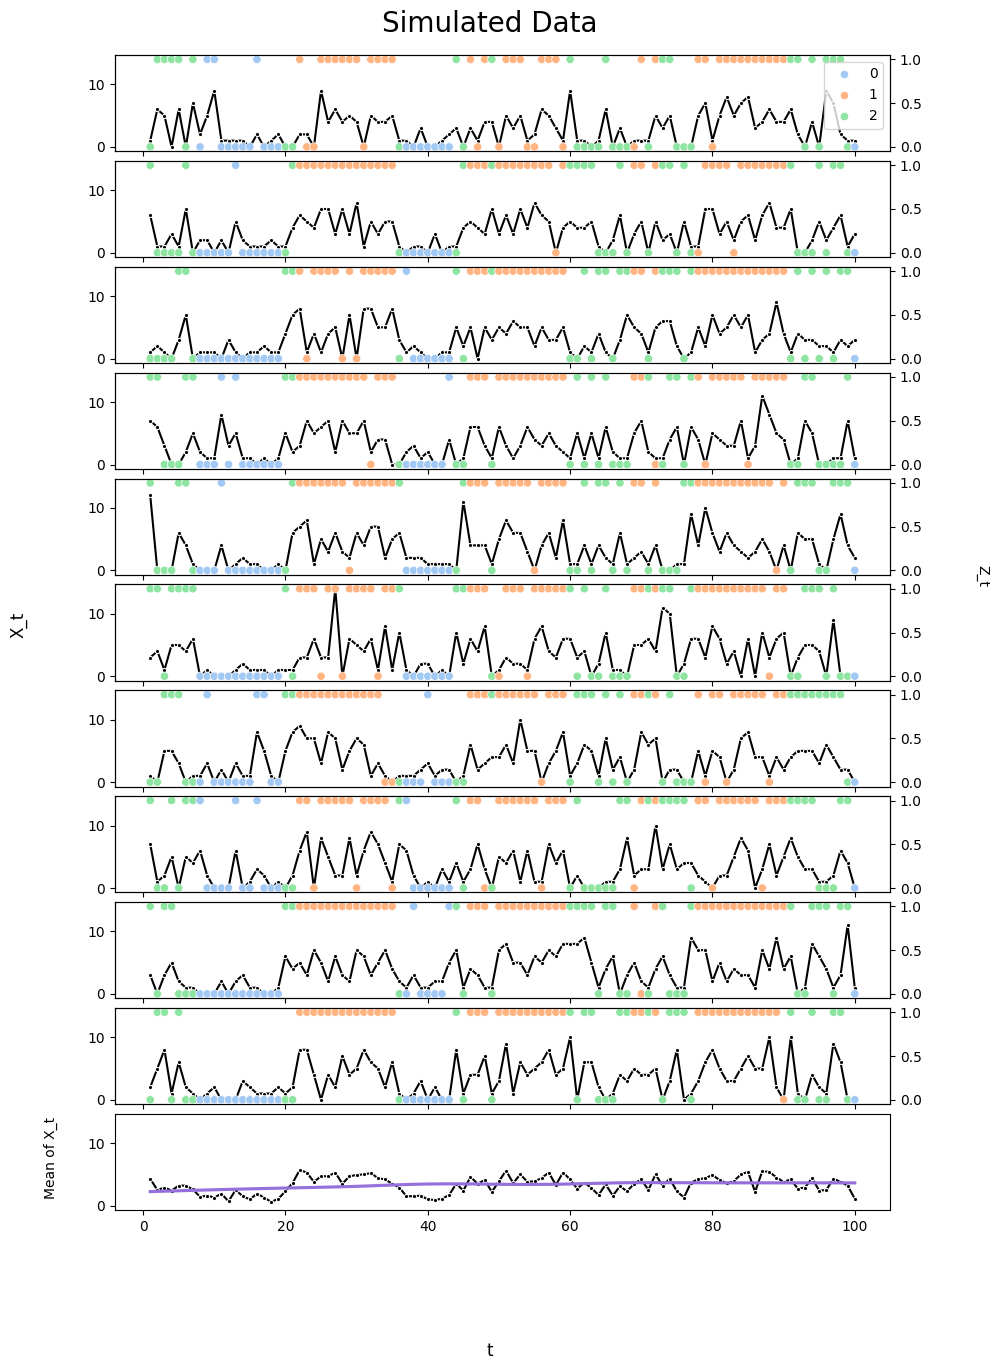

In [150]:
sns.set_palette('bright')

# subplots
fig, axs = plt.subplots(11,1, sharey=True, figsize = (10,15))

# x_axis
x_plot = list(range(1, 100+1))

# plot creations
for i in range(10):
    y_plot = X[i]
    z_plot = Z[i]
    sns.lineplot(x=x_plot, y=y_plot, marker='o', markersize=3, color='black', ax=axs[i], legend=False)#, label='X')
    axs_ = axs[i].twinx()
    if i == 0:
        sns.scatterplot(x=x_plot, y=z_plot, marker='o', ax=axs_, hue=C, palette = 'pastel', legend=True)#, label='Z')
        plt.legend(title = 'C_t')
        plt.legend(loc='upper right')

    else:
        sns.scatterplot(x=x_plot, y=z_plot, marker='o', ax=axs_, hue=C, palette = 'pastel', legend=False)#, label='Z')

# sub-titles
        
fig.suptitle('Simulated Data', fontsize=20, y = 0.91)
fig.supxlabel('t')
fig.supylabel('X_t')
plt.text(117, 5.9, 'Z_t', rotation = 270) #horrible, but it works :)

# creating sub-plot for average
average_x = np.mean(X, axis=0)
sns.lineplot(x=x_plot, y=average_x, marker='o', markersize=3, color='black', ax=axs[10], legend=False)
sns.regplot(x=x_plot, y=average_x, ax=axs[10], scatter=False, color='mediumpurple', lowess=True)
plt.text(-14, -1.1, 'Mean of X_t', rotation = 90)


plt.subplots_adjust(hspace = 0.1)

plt.show()

# Logistic regression

In [12]:
N = 100
n2 = 10
T = 100

#Training set
np.random.seed(42)
C, Z, X = np.empty(shape=(N,T)), np.empty(shape=(N,n2,T)), np.empty(shape=(N, n2,T))
for i in range(N):
    C[i], Z[i], X[i] = model.sim_data(n = n2, T = T)

# Test set
np.random.seed(80)
N_test = 100
C_test, Z_test, X_test = np.empty(shape=(N_test,T)), np.empty(shape=(N_test,n2,T)), np.empty(shape=(N_test, n2, T))
for i in range(N_test):
    C_test[i], Z_test[i], X_test[i] = model.sim_data(n = n2,T = T)

#### Model 1

In [13]:
#Model 1 - using all X's

#Defining regression model
lr_model1 = LogisticRegression(max_iter=10000)
X_model1 = X[:,:,:].reshape((N, 100*n2))
lr_model1.fit(X_model1, C[:,49])   # [49] is C_50 because of zero-indexing
X_model1_test = X_test[:,:,:].reshape((N_test, 100*n2))

In [14]:
# accuracy
np.mean(lr_model1.predict(X_model1_test) == C_test[:,49])

0.67

#### Model 2

In [15]:
#Model 2 - using only neighbouring X's

lr_model2 = LogisticRegression(max_iter=10000)
X_model2 = X[:,:,48:51].reshape((N, 3*n2))
lr_model2.fit(X_model2, C[:,49])
X_model2_test = X_test[:,:,48:51].reshape((N_test, 3*n2))

In [16]:
np.mean(lr_model2.predict(X_model2_test) == C_test[:,49])

0.8

#### Model 3

In [17]:
#Model 3 - using only descendant X's

lr_model3 = LogisticRegression(max_iter=10000)
X_model3 = X[:,:,49].reshape((N, n2))
lr_model3.fit(X_model3, C[:,49])
X_model3_test = X_test[:,:,49].reshape((N_test, n2))


In [18]:
np.mean(lr_model3.predict(X_model3_test) == C_test[:,49])

0.67

#### Model 4

In [20]:
#Model 4 - using only neighbouring X's

lr_model4 = LogisticRegression(max_iter=5000)
X_model4 = X[:,:,0:39].reshape((N, 39*n2))
lr_model4.fit(X_model4, C[:,49])
X_model4_test = X_test[:,:,0:39].reshape((N_test, 39*n2))


In [21]:
np.mean(lr_model4.predict(X_model4_test) == C_test[:,49])

0.34

## Adjusting Alpha

In [35]:
def adjust_vals(valuelist):
    
    
    model1, model2, model3, model4, values = [],[],[],[],[]
    
    
    N = 1000
    n2 = 10
    T = 100

    #Training set
    np.random.seed(42)
    
    
    for val in valuelist:
        
        #initialize
        
        
        model = Markov_model(alpha = val, T = T, n = n2)
        
        
        # Data creation

        C, Z, X = np.empty(shape=(N,T)), np.empty(shape=(N,n2,T)), np.empty(shape=(N, n2,T))
        for i in range(N):
            C[i], Z[i], X[i] = model.sim_data()  # n2,T) #HERE

        N_test = 100
        C_test, Z_test, X_test = np.empty(shape=(N_test,T)), np.empty(shape=(N_test,n2,T)), np.empty(shape=(N_test, n2, T))
        for i in range(N_test):
            C_test[i], Z_test[i], X_test[i] = model.sim_data() #n2,T) #HERE
            
        #Model 1 - using all X's
        lr_model1 = LogisticRegression(max_iter=10000)
        X_model1 = X[:,:,:].reshape((N, 100*n2))
        lr_model1.fit(X_model1, C[:,49]) 
        X_model1_test = X_test[:,:,:].reshape((N_test, 100*n2))

        accuracy_mod1 = np.mean(lr_model1.predict(X_model1_test) == C_test[:,49])
        model1.append(accuracy_mod1)


        #Model 2 - using only neighbouring X's
        lr_model2 = LogisticRegression(max_iter=10000)
        X_model2 = X[:,:,48:51].reshape((N, 3*n2))
        lr_model2.fit(X_model2, C[:,49])
        X_model2_test = X_test[:,:,48:51].reshape((N_test, 3*n2))

        accuracy_mod2 = np.mean(lr_model2.predict(X_model2_test) == C_test[:,49])
        model2.append(accuracy_mod2)
        

        #Model 3 - using only descendant X's  
        lr_model3 = LogisticRegression(max_iter=10000)
        X_model3 = X[:,:,49].reshape((N, n2))
        lr_model3.fit(X_model3, C[:,49])
        X_model3_test = X_test[:,:,49].reshape((N_test, n2))

        accuracy_mod3 = np.mean(lr_model3.predict(X_model3_test) == C_test[:,49])
        model3.append(accuracy_mod3)


        #Model 4 - using only neighbouring X's
        lr_model4 = LogisticRegression(max_iter=5000)
        X_model4 = X[:,:,0:39].reshape((N, 39*n2))
        lr_model4.fit(X_model4, C[:,49])
        X_model4_test = X_test[:,:,0:39].reshape((N_test, 39*n2))

        accuracy_mod4 = np.mean(lr_model4.predict(X_model4_test) == C_test[:,49])
        model4.append(accuracy_mod4)
                                       
        values.append(val)
    
                                       
    df = pd.DataFrame({
    'Model 1': model1,
    'Model 2': model2,
    'Model 3': model3,
    'Model 4': model4,
    'Value': values
    })
                                       
    
    return df

        

In [36]:
# creating values of alpha to interate over
vals_list = np.arange(0.01,1,0.05)

In [37]:
alpha_df = adjust_vals(valuelist = vals_list)

In [38]:
alpha_df

,Model 1,Model 2,Model 3,Model 4,Value
0,0.79,0.98,0.94,0.40,0.01
1,0.78,0.93,0.87,0.42,0.06
2,0.80,0.88,0.75,0.35,0.11
3,0.79,0.90,0.81,0.28,0.16
4,0.65,0.81,0.62,0.23,0.21
5,0.60,0.70,0.71,0.33,0.26
6,0.58,0.71,0.62,0.34,0.31
7,0.43,0.61,0.43,0.35,0.36
8,0.51,0.61,0.49,0.34,0.41
9,0.39,0.39,0.47,0.30,0.46


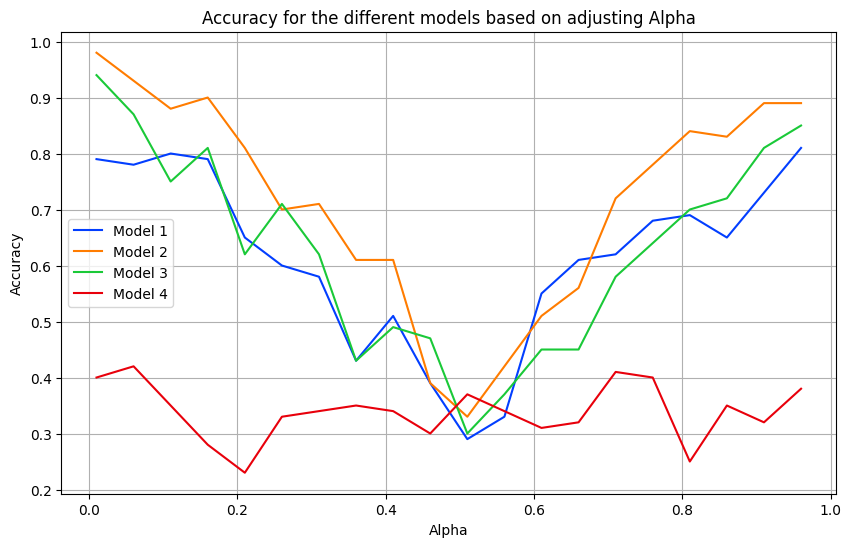

In [39]:
df = alpha_df

# Plot
plt.figure(figsize=(10, 6))

# Plot lines
plt.plot(df['Value'], df['Model 1'], label='Model 1')
plt.plot(df['Value'], df['Model 2'], label='Model 2')
plt.plot(df['Value'], df['Model 3'], label='Model 3')
plt.plot(df['Value'], df['Model 4'], label='Model 4')


plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy for the different models based on adjusting Alpha')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

# Part 2 - Inference of hidden nodes

## Test the inference algorithm using simulated data

Checking the mean of the random variables $1(Z_{tj} = z) - P(Z_{tj} = z|\textbf{X})$ and $1(C_{t} = c) - P(C_{t} = c|\textbf{X})$. 

In [172]:
np.random.seed(42)
model = Markov_model(T = 100, n = 10)
check_simulation(N = 1000, model = model)

Did N =  1000  simulations with n =  10  and T =  100
greatest error for C is: 1.87 %
greatest error for Z is: 3.53 %
mean error for C is: 0.37 %
mean error for Z is: 0.64 %
Accuracy for estimates of C: 
 [[ 0.   -0.   -0.   -0.02  0.    0.01 -0.   -0.01 -0.01 -0.   -0.   -0.01
  -0.   -0.    0.    0.   -0.   -0.    0.    0.01  0.01  0.   -0.    0.
  -0.   -0.01 -0.01 -0.    0.01  0.    0.   -0.    0.   -0.   -0.   -0.01
   0.    0.    0.01  0.    0.   -0.    0.01 -0.   -0.    0.    0.   -0.01
   0.01  0.01  0.   -0.    0.01  0.    0.    0.   -0.01 -0.    0.   -0.
  -0.    0.    0.   -0.   -0.    0.   -0.    0.    0.   -0.   -0.   -0.
   0.    0.01  0.   -0.    0.    0.    0.    0.    0.   -0.01  0.    0.
  -0.   -0.   -0.    0.    0.   -0.   -0.    0.    0.    0.    0.    0.
  -0.   -0.   -0.   -0.  ]
 [ 0.   -0.01 -0.   -0.   -0.01  0.01  0.    0.    0.   -0.    0.   -0.
   0.01  0.    0.01  0.01  0.01  0.01  0.   -0.    0.    0.    0.    0.
   0.01  0.01  0.01  0.    0.    0.   -0. 

Checking prediction accuracy

In [126]:
np.random.seed(42)
model = Markov_model(T = 100, n = 10)
model.sim_data()
model.message_pass()
check_simulation2(model)

The Markov Model with T =  100  and n =  10  predicts the C_t's with accuracy:  0.94  and the Z_ti's with accuracy:  0.906


In [68]:
model = Markov_model(T = 100, n = 10)
model.sim_data()
model.X.shape

(10, 100)

## Apply the inference algorithm on the data in the data file and present the results

Defining a function for reshaping data:

In [174]:
def reshape_data(data):
    T = data.shape[0]
    n = data.shape[1] - 1
    new_data = np.empty(shape = (n,T))
    for i in range(n):
        for t in range(T):
            new_data[i,t] = (data.iloc[t,i+1])
    return new_data

Importing data:

In [175]:
import pandas as pd
Ex_1 = reshape_data(pd.read_csv("Ex_1.csv"))
Ex_2 = reshape_data(pd.read_csv("Ex_2.csv"))
Ex_3 = reshape_data(pd.read_csv("Ex_3.csv"))
Ex_4 = reshape_data(pd.read_csv("Ex_4.csv"))
Ex_5 = reshape_data(pd.read_csv("Ex_5.csv"))
Ex_6 = reshape_data(pd.read_csv("Ex_6.csv"))
Ex_7 = reshape_data(pd.read_csv("Ex_7.csv"))
Ex_8 = reshape_data(pd.read_csv("Ex_8.csv"))
Ex_9 = reshape_data(pd.read_csv("Ex_9.csv"))
Ex_10 =reshape_data(pd.read_csv("Ex_10.csv"))

Application and presentation 1: 

In [187]:
def application_presentation(data):

    # Application
    T = data.shape[1]
    n = data.shape[0]-1
    model = Markov_model(T = T, n = n)
    model.X = data
    model.message_pass()
    model.find_most_probable()

    # Presentation
    sns.set_palette('bright')

    # subplots
    fig, axs = plt.subplots(n + 1,1, sharey=True, figsize = (10,15))

    # x_axis
    x_plot = list(range(1, T+1))

    # plot creations
    for i in range(n):
        y_plot = model.X[i]
        z_plot = model.Z_guess[i]
        sns.lineplot(x=x_plot, y=y_plot, marker='o', markersize=3, color='black', ax=axs[i], legend=False)#, label='X')
        axs_ = axs[i].twinx()
        if i == 0:
            sns.scatterplot(x=x_plot, y=z_plot, marker='o', ax=axs_, hue=model.C_guess, palette = 'pastel', legend=True)#, label='Z guess')
            plt.legend(title = 'C_t guess')
            plt.legend(loc='upper right')

        else:
            sns.scatterplot(x=x_plot, y=z_plot, marker='o', ax=axs_, hue=model.C_guess, palette = 'pastel', legend=False)#, label='Z guess')

    # sub-titles

    fig.suptitle('Inferred Values', fontsize=20, y = 0.91)
    fig.supxlabel('t')
    fig.supylabel('X_t')
    plt.text(117, 5.9, 'Z_t', rotation = 270) #horrible, but it works :)

    # creating sub-plot for average
    average_x = np.mean(model.X, axis=0)
    sns.lineplot(x=x_plot, y=average_x, marker='o', markersize=3, color='black', ax=axs[n], legend=False)
    sns.regplot(x=x_plot, y=average_x, ax=axs[n], scatter=False, color='mediumpurple', lowess=True)
    plt.text(-14, -1.1, 'Mean of X_t', rotation = 90)


    plt.subplots_adjust(hspace = 0.1)

    plt.show()

    return
    

1.41


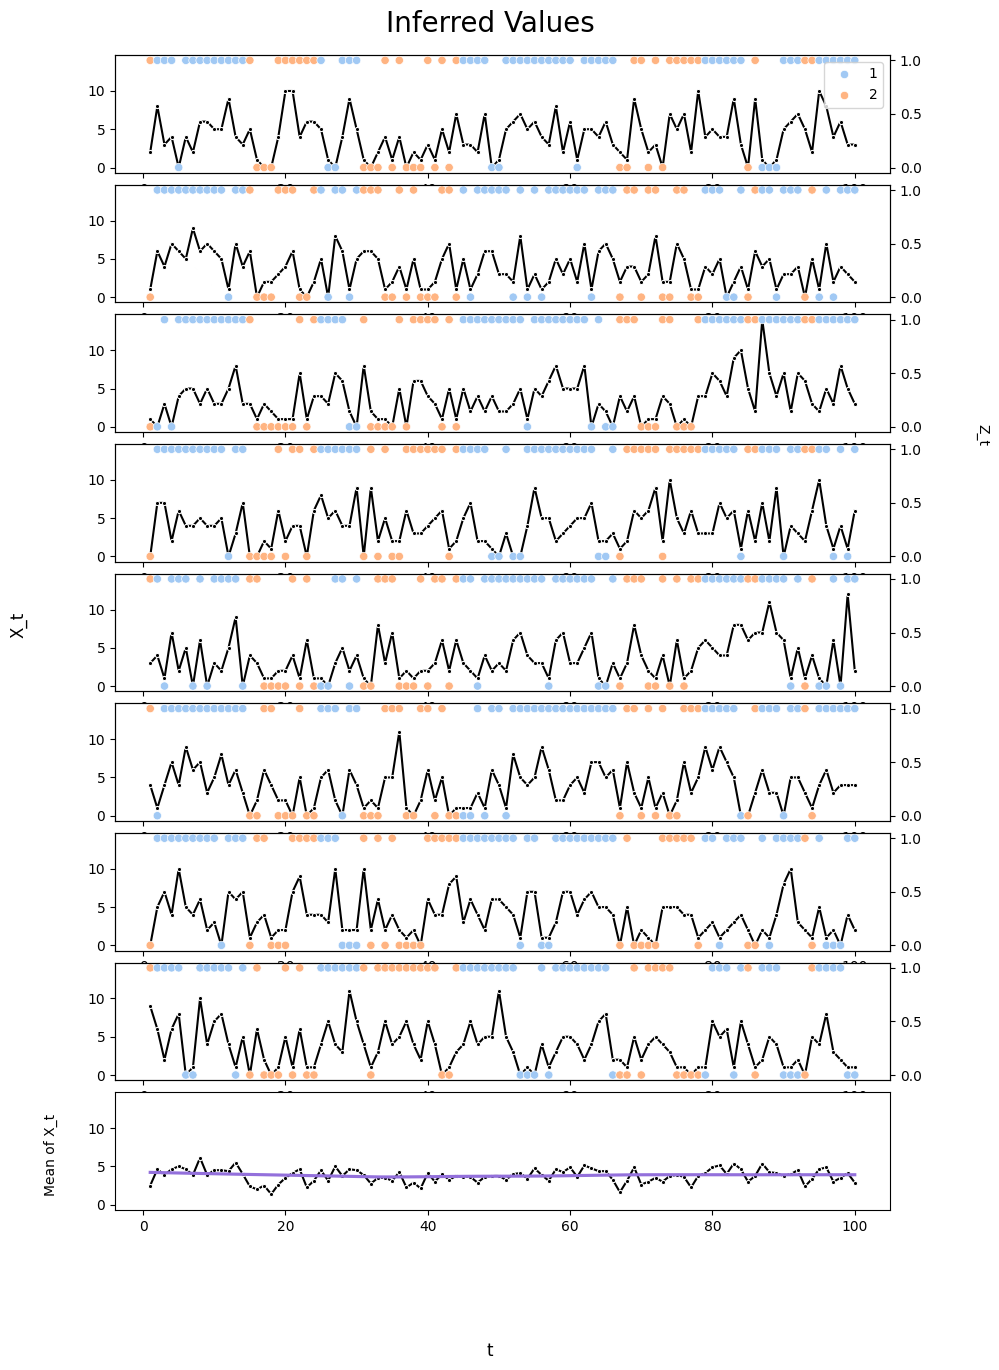

In [189]:
application_presentation(Ex_1)

In [ ]:
# Presentation
sns.set_palette('bright')

# subplots - One for each data file
fig, axs = plt.subplots(10,1, sharey=True, figsize = (10,15))

# for loop for every data file

data_real = [Ex_1,Ex_2,Ex_3,Ex_4,Ex_5,Ex_6,Ex_7,Ex_8,Ex_9,Ex_10]

for i in range(10):

    # Shapes
    T = data_real[i].shape[1]
    n = data_real[i].shape[0]

    # Model
    model = Markov_model(T = T, n = n)
    model.X = data_real[i]
    model.message_pass()
    model.find_most_probable()

    # Data
    x_plot = list(range(1, T+1))
    average_x = np.mean(model.X, axis=0)
    average_z = np.mean(model.Z_guess, axis=0)

    axs_ = axs[i].twinx()
    if i == 0:
        # Average X_{ti}
        sns.lineplot(x=x_plot, y=average_x, marker='o', markersize=3, legend = True,
                     color='blue', ax=axs[i], linestyle='-', label='X_t')
        # Average Z_{ti}
        sns.lineplot(x=x_plot, y=average_z, color='black', ax=axs_, linestyle='--', legend = False,
                     alpha = 0.6, label='Mean inferred Z_t')
        # C_t
        sns.scatterplot(x=x_plot, y=average_z, ax=axs_, hue=model.C_guess,
                        style=model.C_guess, markers=['o', 's', '^'], legend = False, palette = 'Set2')
        plt.legend(loc='upper right')
        plt.legend(title = 'Lines')
    if i == 1:
        # Average X_{ti} 
        sns.lineplot(x=x_plot, y=average_x, marker='o', markersize=3, 
                     color='blue', ax=axs[i], linestyle='-')

        # Average Z_{ti} 
        sns.lineplot(x=x_plot, y=average_z, color='black', 
                     ax=axs_, linestyle='--', alpha = 0.6)

        # C_t
        sns.scatterplot(x=x_plot, y=average_z, ax=axs_, hue=model.C_guess, 
                        legend=True, markers=['o', 's', '^'], style=model.C_guess, palette = 'Set2')
        plt.legend(loc='upper right')
        plt.legend(title = 'C_t guess')
    else:
        sns.lineplot(x=x_plot, y=average_x, marker='o', 
                     markersize=3, color='blue', ax=axs[i])
        sns.lineplot(x=x_plot, y=average_z, markersize=3, 
                     color='black', linestyle='--', ax=axs_, alpha = 0.6)
        sns.scatterplot(x=x_plot, y=average_z, ax=axs_, hue = model.C_guess, 
                        markers=['o', 's', '^'], legend=False, style = model.C_guess, palette = 'Set2')

plt.subplots_adjust(hspace=0.1)

fig.suptitle('Inferred Values', fontsize=20, y=0.91)
fig.supxlabel('t')
fig.supylabel('Mean X_t')
plt.text(117, 5.9, 'Mean inferred Z_t', rotation=270) 

plt.show()

# Learning

In [11]:
model = Markov_model()
model.sim_data(T = 100, return_output=False)

Below is a function for computing parameter estimates

In [ ]:
def learn_par(model, Print = False):
    n = model.n
    T = model.T
    Z = model.Z #n, T
    C = model.C #T
    X = model.X #n, T
    
    # Estimating lambda's
    lambda0_hat = np.sum((1-Z) * X) / (np.sum(1-Z))
    lambda1_hat = np.sum(Z * X) / np.sum(Z)

    # # Estimating alpha_hat
    if(np.sum(C==2) == T):
        return print("WARNING: No C==1 nor C== 0 have been observed and learning cannot proceed")

    alpha_hat  =  np.sum(Z == C)  / (np.sum(C != 2)*n)
    beta_hat   =  np.mean((C[:-1] == 2) & (C[1:] != 2)) / np.mean(C[:-1] == 2)
    gamma_hat  =  np.mean((C[:-1] != 2) & (C[1:] == 2)) / np.mean(C[:-1] != 2)

    if (Print == True):
        print("lambda0_hat is: ", lambda0_hat, "\n lambda1_hat is: ", lambda1_hat, "\nalpha_hat is:", alpha_hat, "\nbeta_hat is: ", beta_hat, "\ngamme_hat is: ", gamma_hat)
    
    model.estimates = {
        "lamb0_hat": lambda0_hat,
        "lamb1_hat": lambda1_hat,
        "alpha_hat": alpha_hat,
        "beta_hat":  beta_hat,
        "gamma_hat": gamma_hat
    }
    return model.estimates

In [13]:
learn_par(model)

{'lamb0_hat': 0.8817204301075269,
 'lamb1_hat': 5.08411214953271,
 'alpha_hat': 0.9087179487179488,
 'beta_hat': 0.11428571428571428,
 'gamma_hat': 0.0625}

In [34]:
model.sim_data(T = 100)
print(learn_par(model))
print(model.model_values)

{'lamb0_hat': 1.0127414714344432, 'lamb1_hat': 5.010128554733152, 'alpha_hat': 0.8991285714285715, 'beta_hat': 0.17391304347826086, 'gamma_hat': 0.1509433962264151}
[1, 5, 0.9, 0.2, 0.1]


Test the implementation using simulated data

In [132]:
N_rep = 100

model = Markov_model(gamma = 0.4, T = 1000, n = 100)
par_estimates = np.empty(shape =(N_rep,5))
for i in range(N_rep):
    model.sim_data(return_output=False)
    estimate_i = learn_par(model)
    par_estimates[i, 0] = estimate_i["lamb0_hat"]
    par_estimates[i, 1] = estimate_i["lamb1_hat"]
    par_estimates[i, 2] = estimate_i["alpha_hat"]
    par_estimates[i, 3] = estimate_i["beta_hat"]
    par_estimates[i, 4] = estimate_i["gamma_hat"]   

In [133]:
names = ["lambda0", "lambda1", "alpha", "beta", "gamma"]
true_vals = [model.lamb0, model.lamb1, model.alpha, model.beta, model.gamma]

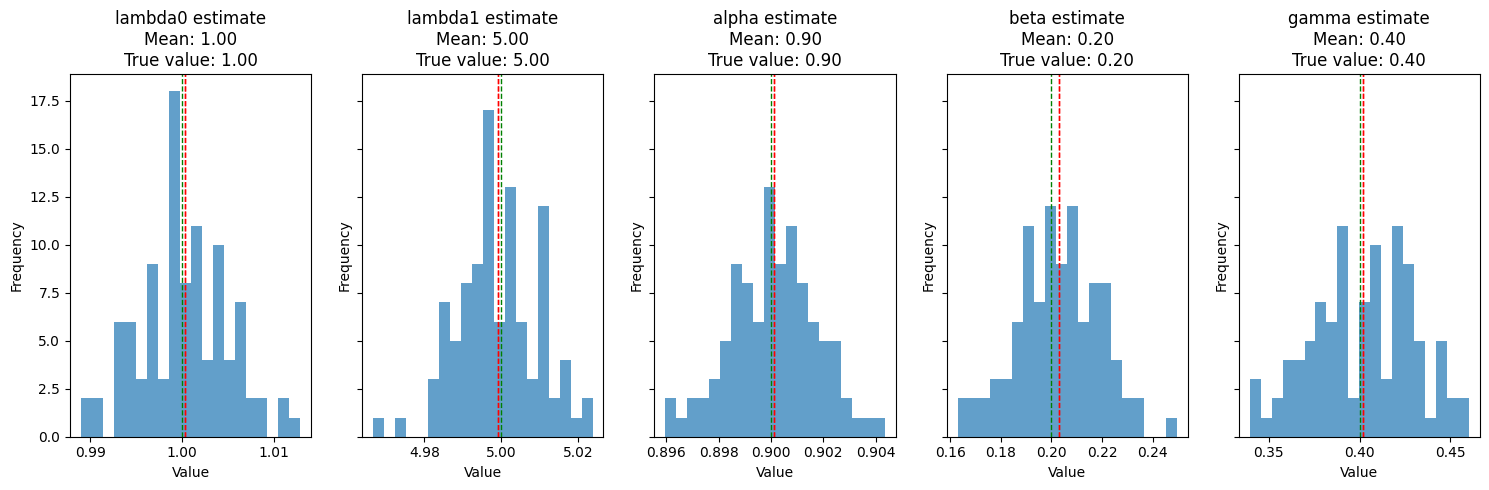

In [134]:
# Create subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Iterate through each subplot
for i, ax in enumerate(axes):
    # Plot histogram
    ax.hist(par_estimates[:,i], bins=20, alpha=0.7)
    
    # Add line for mean and true value
    mean_value = np.mean(par_estimates[:,i])
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
    ax.axvline(true_vals[i], color='green', linestyle='dashed', linewidth=1)
    
    # Set title and labels
    ax.set_title(f'{names[i]} estimate\nMean: {mean_value:.2f}\nTrue value: {true_vals[i]:.2f}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('histograms_with_means.png')
plt.show()

In [15]:
#---- EM ----
def hardEM(X, convergence_limit = 1e-5, limit = 100, initial_dic = {'lamb0_hat': 1, 'lamb1_hat': 10, 'alpha_hat': 0.9, 'beta_hat': 0.5, 'gamma_hat': 0.5}, verbose = 0):
    data_n = X.shape[0]
    data_T = X.shape[1]
    model = Markov_model(n = data_n, T = data_T)
    model.X = X
    
    #Updating working model
    distance = 100
    model.alpha = initial_dic["alpha_hat"]
    model.beta  = initial_dic["beta_hat"]
    model.gamma = initial_dic["gamma_hat"]
    model.lamb0 = initial_dic["lamb0_hat"]
    model.lamb1 = initial_dic["lamb1_hat"]
    if verbose > 0:
        print("initial_values are", model.model_values)
    model.update_values()
    current_est  = np.empty(shape = (limit+1,5 ))
    current_est[0] = list(initial_dic.values())
    #Resetting the timer
    N = 0
    distance = 10
    while (N<limit) & (distance > convergence_limit):
        N += 1
        
        model.message_pass()
        C_guess = np.argmax(model.C_prob, axis = 1) #(T)
        Z_guess = np.argmax(model.belief_Zij, axis = 2) #(n T Z)
        model.C = C_guess
        model.Z = Z_guess
        
        parameter_guess = learn_par(model)

        #Update model values
        model.alpha = parameter_guess["alpha_hat"]
        model.beta = parameter_guess["beta_hat"]
        model.gamma = parameter_guess["gamma_hat"]
        model.lamb0 = parameter_guess["lamb0_hat"]
        model.lamb1 = parameter_guess["lamb1_hat"]
        model.update_values()

        list_parameter_guess = list(parameter_guess.values())
        #Save current estimate
        current_est[N] = list_parameter_guess
        #calculate distance
        distance = np.max(current_est[N-1]-current_est[N])

    if verbose > 0:
        if(N < limit):
            print("Convergence acheived after N =  ", N, "steps")
            current_est = current_est[0:(N+1),:]
        else:
            print("No convergence after N = ", limit, "steps")
    
    model.estimates = parameter_guess

    return model.estimates, current_est



In [40]:
true_model = Markov_model()
true_model.sim_data(T = 1000, n = 100)
test_X = true_model.X
true_model.alpha

0.9

In [43]:
initial_dic = {'lamb0_hat': 1, 'lamb1_hat': 10, 'alpha_hat': 0.6, 'beta_hat': 0.5, 'gamma_hat': 0.5} 
final, est_list = hardEM(test_X, limit = 50, initial_dic=initial_dic, convergence_limit=0.001)
final, true_model.model_values

initial_values are [1, 10, 0.6, 0.5, 0.5]
Convergence acheived after N =   5 steps


({'lamb0_hat': 0.9281832606108688,
  'lamb1_hat': 5.1557482855990315,
  'alpha_hat': 0.8915909107986866,
  'beta_hat': 0.27037037037037037,
  'gamma_hat': 0.09876543209876543},
 [1, 5, 0.9, 0.2, 0.1])

In [ ]:

def learn_par_soft(model, Print = False):
    n = model.n
    T = model.T
    Z = model.belief_Zij #n, T, 2
    C = model.C_prob #T, 3
    X = model.X  #n, T
    
    # Estimating lambda's
    lambda0_hat = np.sum(Z[:,:,0] * X) / (np.sum(Z[:,:,0]))
    lambda1_hat = np.sum(Z[:,:,1] * X) / np.sum(Z[:,:,1])

    # # Estimating alpha_hat
    if(np.sum(C[:,2]) == T):
        return print("WARNING: No C==1 nor C== 0 have been observed and learning cannot proceed")

    alpha_hat =  np.mean(C[:,0] * Z[:,:,0] + C[:,1] * Z[:,:,1]) / (np.mean(C[:,0] + C[:,1]))
    beta_hat  =  np.mean(C[:-1,2] * (C[1:,0] + C[1:,1])) / np.mean(C[:-1,2])
    gamma_hat =  np.mean((C[:-1,0] + C[:-1,1]) * C[1:,2]) / np.mean(C[:-1,0] + C[:-1,1])

    if (Print == True):
        print("lambda0_hat is: ", lambda0_hat, "\n lambda1_hat is: ", lambda1_hat, "\nalpha_hat is:", alpha_hat, "\nbeta_hat is: ", beta_hat, "\ngamme_hat is: ", gamma_hat)
    

    model.estimates = {
        "lamb0_hat": lambda0_hat,
        "lamb1_hat": lambda1_hat,
        "alpha_hat": alpha_hat,
        "beta_hat":  beta_hat,
        "gamma_hat": gamma_hat
    }
    return model.estimates

In [ ]:
#---- soft EM ----
def softEM(X, convergence_limit = 1e-6, limit = 500, initial_dic = {'lamb0_hat': 1, 'lamb1_hat': 10, 'alpha_hat': 0.9, 'beta_hat': 0.5, 'gamma_hat': 0.5}, verbose=0):
    data_n = X.shape[0]
    data_T = X.shape[1]
    model = Markov_model(n = data_n, T = data_T)
    model.X = X
    
    #Updating working model
    distance = 100
    model.alpha = initial_dic["alpha_hat"]
    model.beta = initial_dic["beta_hat"]
    model.gamma = initial_dic["gamma_hat"]
    model.lamb0 = initial_dic["lamb0_hat"]
    model.lamb1 = initial_dic["lamb1_hat"]
    if verbose > 0:
        print("initial_values are", model.model_values)
    model.update_values()
    current_est  = np.empty(shape = (limit+1,5 ))
    current_est[0] = list(initial_dic.values())
    #Resetting the timer
    N = 0
    distance = 10
    while (N<limit) & (distance > convergence_limit):
        N += 1
        
        model.message_pass()
        parameter_guess = learn_par_soft(model)

        #Update model values
        model.alpha = parameter_guess["alpha_hat"]
        model.beta = parameter_guess["beta_hat"]
        model.gamma = parameter_guess["gamma_hat"]
        model.lamb0 = parameter_guess["lamb0_hat"]
        model.lamb1 = parameter_guess["lamb1_hat"]
        model.update_values()

        list_parameter_guess = list(parameter_guess.values())
        #Save current estimate
        current_est[N] = list_parameter_guess
        #calculate distance
        distance = np.max(current_est[N-1]-current_est[N])

    if verbose > 0:
        if(N < limit):
            print("Convergence achieved after N =  ", N, "steps")
            current_est = current_est[0:(N+1),:]
        else:
            print("No convergence after N = ", limit, "steps")
    
    model.estimates = parameter_guess

    #print(model.C_probs)
    return model.estimates, current_est

true_model = Markov_model(T = 1000, n = 10)
true_model.sim_data()
test_X = true_model.X
final, est_list = softEM(test_X, limit = 200, initial_dic=initial_dic)
final, true_model.model_values

0.4456855283971495 0.07355696958159097 0.6733384716392523
0.4238379685748709 0.18273142664601086 0.7718629619703913
0.3827175596296134 0.23438727773246054 0.7852985616539703
0.3560010874260557 0.25728269800720793 0.7787978736665313
0.3400239325482614 0.2676414647649224 0.7685784821015218
0.3304759134327633 0.2717984771952578 0.7581958195395941
0.32455466034204666 0.2728024080783183 0.7484212530590316
0.3206710502867145 0.27224187336733124 0.7394299577192346
0.31796535968148526 0.2709651543885649 0.7312797052996306
0.3159787188899096 0.26942732352550114 0.7240011244339841
0.31446381175362303 0.26787011369387775 0.7176050486782474
0.3132821619274825 0.2664171200800335 0.7120774526783065
0.31235046683483825 0.2651251650312161 0.7073778433288722
0.3116135914827908 0.264012929530765 0.7034429361158833
0.3110315032852118 0.2630776108432243 0.7001936709360308
0.310573150446363 0.26230498996108476 0.6975431313677304
0.3102135962944627 0.261675624120293 0.6954035894361009
0.309932577930708 0.26

({'lamb0_hat': 0.9785869012493225,
  'lamb1_hat': 4.937506717920524,
  'alpha_hat': 0.8265996520847713,
  'beta_hat': 0.30398553145884966,
  'gamma_hat': 0.1374435083163981},
 [1, 5, 0.9, 0.2, 0.1])

In [ ]:
N_rep = 100

initial_dic = {'lamb0_hat': 1, 'lamb1_hat': 10, 'alpha_hat': 0.95, 'beta_hat': 0.5, 'gamma_hat': 0.5} 
model = Markov_model(gamma = 0.4, T = 1000, n = 100)
test_X = true_model.X
final, est_list = softEM(test_X, limit = 50, initial_dic=initial_dic)
final, true_model.model_values

par_estimates_hardEM = np.empty(shape =(N_rep,5))
for i in range(N_rep):
    model.sim_data(return_output=False)
    estimate_i, _ = hardEM(model.X)
    par_estimates_hardEM[i, 0] = estimate_i["lamb0_hat"]
    par_estimates_hardEM[i, 1] = estimate_i["lamb1_hat"]
    par_estimates_hardEM[i, 2] = estimate_i["alpha_hat"]
    par_estimates_hardEM[i, 3] = estimate_i["beta_hat"]
    par_estimates_hardEM[i, 4] = estimate_i["gamma_hat"]   

names = ["lambda0", "lambda1", "alpha", "beta", "gamma"]
true_vals = [model.lamb0, model.lamb1, model.alpha, model.beta, model.gamma]

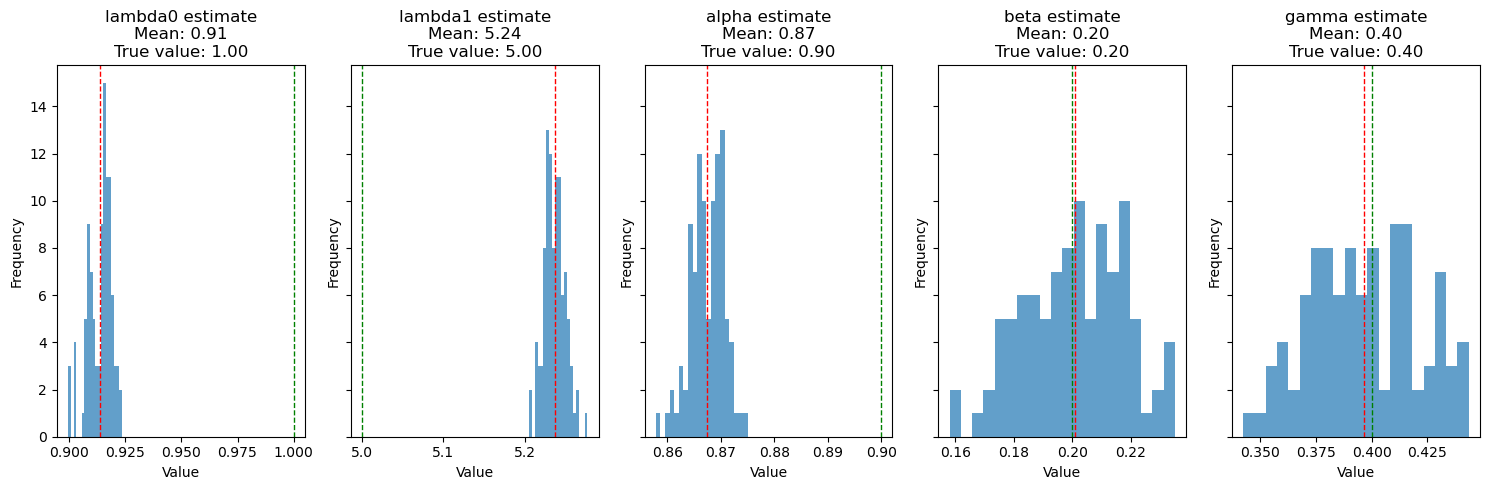

In [ ]:
# Create subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Iterate through each subplot
for i, ax in enumerate(axes):
    # Plot histogram
    ax.hist(par_estimates_hardEM[:,i], bins=20, alpha=0.7)
        
    # Add vertical line for the mean and true values
    mean_value = np.mean(par_estimates_hardEM[:,i])
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
    ax.axvline(true_vals[i], color='green', linestyle='dashed', linewidth=1)
    
    # Set title and labels
    ax.set_title(f'{names[i]} estimate\nMean: {mean_value:.2f}\nTrue value: {true_vals[i]:.2f}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('histograms_with_means.png')
plt.show()

In [ ]:
N_rep = 100

initial_dic = {'lamb0_hat': 1, 'lamb1_hat': 10, 'alpha_hat': 0.6, 'beta_hat': 0.5, 'gamma_hat': 0.5} 
model = Markov_model(gamma = 0.4, T = 1000, n = 100)
test_X = true_model.X
final, est_list = softEM(test_X, limit = 50, initial_dic=initial_dic)
final, true_model.model_values

par_estimates_softEM = np.empty(shape =(N_rep,5))
for i in range(N_rep):
    model.sim_data(return_output=False)
    estimate_i, _ = softEM(model.X)
    par_estimates_softEM[i, 0] = estimate_i["lamb0_hat"]
    par_estimates_softEM[i, 1] = estimate_i["lamb1_hat"]
    par_estimates_softEM[i, 2] = estimate_i["alpha_hat"]
    par_estimates_softEM[i, 3] = estimate_i["beta_hat"]
    par_estimates_softEM[i, 4] = estimate_i["gamma_hat"]   

names = ["lambda0", "lambda1", "alpha", "beta", "gamma"]
true_vals = [model.lamb0, model.lamb1, model.alpha, model.beta, model.gamma]

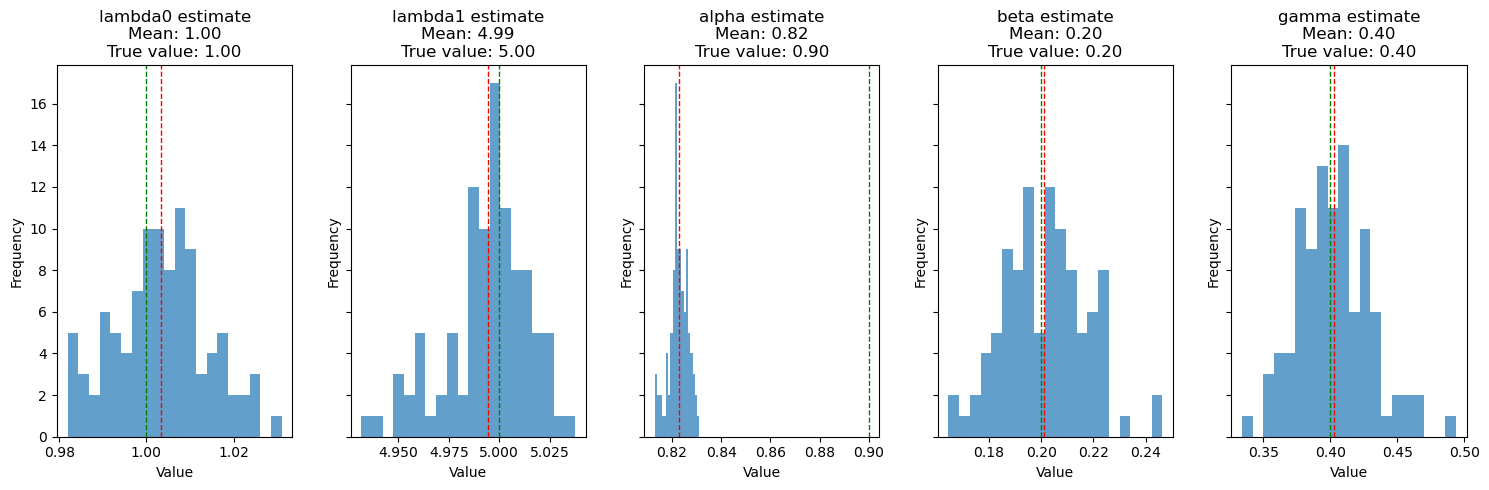

In [ ]:
# Create subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Iterate through each subplot
for i, ax in enumerate(axes):
    # Plot histogram
    ax.hist(par_estimates_softEM[:,i], bins=20, alpha=0.7)
        
    # Add vertical line for the mean and true values
    mean_value = np.mean(par_estimates_softEM[:,i])
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
    ax.axvline(true_vals[i], color='green', linestyle='dashed', linewidth=1)
    
    # Set title and labels
    ax.set_title(f'{names[i]} estimate\nMean: {mean_value:.2f}\nTrue value: {true_vals[i]:.2f}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('histograms_with_means.png')
plt.show()